In [1]:
%matplotlib inline

In [2]:
import requests
import json
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np

from config import nrel_key

In [3]:
#NREL's Transportation Laws and Incentives API

technology = "ELEC"
incentive_type = "TAX"


params = {
    "api_key": nrel_key,
    "technology": technology
    }

base_url = f"https://developer.nrel.gov/api/transportation-incentives-laws/v1.json?"

#print(base_url)

response = requests.get(base_url, params=params).json()

df = pd.DataFrame(response["result"])
df.head()

#print(json.dumps(response,indent=4, sort_keys=True))

,id,state,title,text,enacted_date,amended_date,plaintext,is_recent,seq_num,type,agency,significant_update_date,recent_update_or_new,utility_id,county_ids,technologies,categories,types,references,topics
0,284,US,Congestion Mitigation and Air Quality (CMAQ) I...,<p>The CMAQ Program provides funding to state ...,2005-08-10T00:00:00Z,2021-11-15T00:00:00Z,The CMAQ Program provides funding to state dep...,False,54.0,Incentives,U.S. Department of Transportation,11/29/2021,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ETH, ELEC, HY, IR, NG, PHEV, LPG]","[{'code': 'STATION', 'title': 'Alternative Fue...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
1,288,US,Clean Cities Coalition Network,The mission of Clean Cities Coalition Network ...,None,None,The mission of Clean Cities Coalition Network ...,False,21.0,Programs,U.S. Department of Energy,None,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[AFTMKTCONV, BIOD, ETH, ELEC, EFFEC, HEV, HY, ...","[{'code': 'AFTMKTCONV', 'title': 'Aftermarket ...","[{'id': 9, 'title': 'Programs', 'code': 'PROG'}]",[],[]
2,317,US,State Energy Program (SEP) Funding,The SEP provides grants to states to assist in...,None,2021-11-15T00:00:00Z,The SEP provides grants to states to assist in...,False,26.0,Incentives,U.S. Department of Energy,11/29/2021,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ETH, ELEC, EFFEC, HY, NG, PHEV, LPG]","[{'code': 'BIOD', 'title': 'Biodiesel', 'categ...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
3,323,US,Clean School Bus,<p>The U.S. Environmental Protection Agency’s ...,None,2021-11-15T00:00:00Z,The U.S. Environmental Protection Agency's (EP...,False,33.0,Incentives,U.S. Environmental Protection Agency,8/16/2022,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[AFTMKTCONV, ETH, ELEC, EFFEC, HY, IR, NG, PHE...","[{'code': 'AFTMKTCONV', 'title': 'Aftermarket ...","[{'id': 8, 'title': 'Incentives', 'code': 'INC'}]","[{'description': 'Public Law 117-58', 'url': '...",[]
4,324,US,Clean Construction and Agriculture,Clean Construction is a voluntary program that...,None,None,Clean Construction is a voluntary program that...,False,34.0,Programs,U.S. Environmental Protection Agency,None,update,NaN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[BIOD, ELEC, HEV, HY, NG, PHEV, LPG]","[{'code': 'PURCH', 'title': 'Alternative Fuel ...","[{'id': 9, 'title': 'Programs', 'code': 'PROG'}]",[],[]


In [39]:
state_incentives = df.loc[df["type"] == "State Incentives"]

states_sorted = state_incentives.groupby(["state"]).count()['id']

states_sorted.head()

state
AK     1
AL     3
AR     3
AZ     6
CA    41
Name: id, dtype: int64

In [5]:
#Importing US Census' 2022 population estimate (for 7/1/2022) (Annual Estimates of the Resident Population for the United States, Regions, States, District of Columbia, and Puerto Rico: April 1, 2020 to July 1, 2022 (NST-EST2022-POP))

ev_registration_path = "resources/ev_registration_by_state.csv"

registration_data = pd.read_csv(ev_registration_path)

state_pop_path = "resources/2022_est_state_pop.csv"

population_data = pd.read_csv(state_pop_path)

population_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Geographic Area    51 non-null     object
 1   state              51 non-null     object
 2   Population (est.)  51 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [35]:
population_registration_merge = pd.merge(population_data, registration_data, how = "left", on=["state"])

population_registration_merge.dropna(inplace=True)

population_registration_merge["EVs per Capita"] = population_registration_merge["Registration Count"] / population_registration_merge["Population (est.)"]


population_registration_merge.head()

,Geographic Area,state,Population (est.),State Name,Registration Count,EVs per Capita
0,Alabama,AL,5074296,Alabama,4750.0,0.000936
1,Alaska,AK,733583,Alaska,1290.0,0.001758
2,Arizona,AZ,7359197,Arizona,40740.0,0.005536
3,Arkansas,AR,3045637,Arkansas,2390.0,0.000785
4,California,CA,39029342,California,563070.0,0.014427


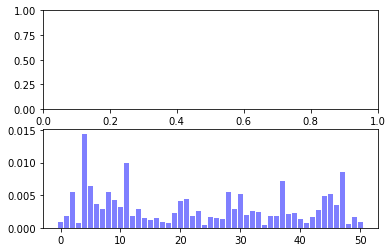

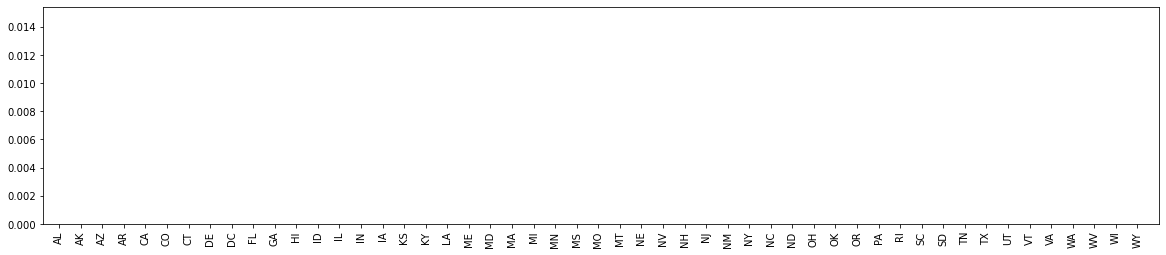

In [ ]:
x_axis = np.arange(len(population_registration_merge))
tick_locations = [value for value in x_axis]

plt.figure(figsize=(20,4))
plt.bar(x_axis, population_registration_merge["Registration Counts"], color='b', alpha=0.5, align="center")
plt.bar(x_axis, population_registration_merge["Registration Counts"], color='b', alpha=0.5, align="center")
plt.xticks(tick_locations, population_registration_merge["state"], rotation="vertical")

plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(population_registration_merge["EVs per Capita"])+.001)

plt.show()

In [32]:
incentives_per_capita = pd.merge(states_sorted, population_registration_merge, how = "left", on=["state"])

incentives_per_capita.rename(columns = {"id":"Number of State Incentives"},inplace=True)

incentives_per_capita.head()

,state,Number of State Incentives,Geographic Area,Population (est.),State Name,Registration Count,EVs per Capita
0,AK,1,Alaska,733583,Alaska,1290.0,0.001758
1,AL,3,Alabama,5074296,Alabama,4750.0,0.000936
2,AR,3,Arkansas,3045637,Arkansas,2390.0,0.000785
3,AZ,6,Arizona,7359197,Arizona,40740.0,0.005536
4,CA,41,California,39029342,California,563070.0,0.014427


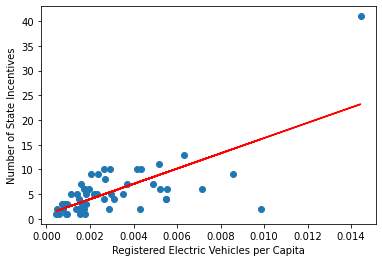

In [59]:
x_values = incentives_per_capita['EVs per Capita']
y_values = incentives_per_capita['Number of State Incentives']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Registered Electric Vehicles per Capita')
plt.ylabel('Number of State Incentives')
plt.show()

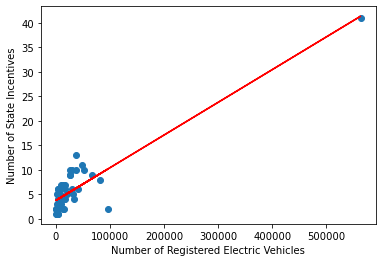

In [58]:
x_values = incentives_per_capita['Registration Count']
y_values = incentives_per_capita['Number of State Incentives']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.xlabel('Number of Registered Electric Vehicles')
plt.ylabel('Number of State Incentives')
plt.show()

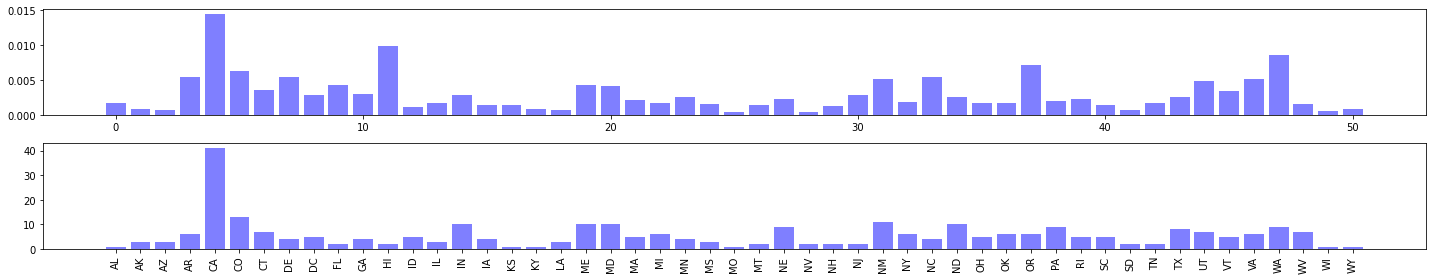

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,4))

x_axis = np.arange(len(incentives_per_capita))
tick_locations = [value for value in x_axis]

ax[0].bar(x_axis, incentives_per_capita["EVs per Capita"], color='b', alpha=0.5, align="center", )
ax[1].bar(x_axis, incentives_per_capita["Number of State Incentives"], color='b', alpha=0.5, align="center")
plt.xticks(tick_locations, population_registration_merge["state"], rotation="vertical")

plt.tight_layout()
# ax[0].xlim(-0.75, len(x_axis))
# ax[1].xlim(-0.75, len(x_axis))
#plt.ylim(0, max(population_registration_merge["EVs per Capita"])+.001)

plt.show()